## BERT on Email Classification
#### This program is used to utilize BERT to verify whether it can improve the performance of supporting email classification in my firm.
####  The detail of BERT can be found in: https://github.com/google-research/bert

This program is consisted of the following:
1. Data preparation for run_classifier.py in BERT: <br />
 1) Load the supporting email data and divide those into 3 files: train.tsv, dev.tsv, test.tsv, 
which is required by run_classifier.py in the sample of BERT.<br />
 2) Revise run_classifier.py with the label list. <br />
 3) After run run_classifer.py for the training / testing, then compare the result of test result.<br />
2. Build the similiar DL structure by keras and compare the result with 1 to see the feasiblity of BERT application. <br />

In addition, the source file in this program was not uploaded, and the audience can create your own by MS excel file, in which, 2 columns, one for input question ( Data x), and one for label ( Data y).

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

In [73]:
import itertools
import os
import logging
import csv        

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Embedding,LSTM,Flatten,GRU,Bidirectional
from keras.preprocessing import text, sequence
from keras import utils

import gensim
from gensim.models import Word2Vec
from gensim.models import FastText

# This code was tested with TensorFlow v1.4
print("You have TensorFlow version", tf.__version__)

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s', 
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)

You have TensorFlow version 1.12.0


### Load the dataset

In [5]:
source = pd.read_excel('../98_data/mail_timesheet_admin.xlsx', encoding='latin-1')
source.head()

,convid,subject,length,tousflag,dialognm,forwardtime,imagenm,notimagenm,mailbody,mailquestion,imagetype,firstanswername,firstforwardname,Category,Unnamed: 14
0,AAQkAGI3MzUxMzk3LTZiZjItNDQ5Ni1hMzJlLWU5NWMxNm...,NaN,26.500000,1,3.0,1,0,0,now personname change target date and able to ...,i can not find anything related to this after ...,NaN,yosong@abeam.com,yosong@abeam.com,Timesheet,NaN
1,AAQkAGI3MzUxMzk3LTZiZjItNDQ5Ni1hMzJlLWU5NWMxNm...,NaN,14.333333,0,2.0,0,0,0,from date from date 9 9 9 9 nasa file expense ...,the from date property in the expense module f...,NaN,NaN,NaN,non-issue,NaN
2,AAQkAGI3MzUxMzk3LTZiZjItNDQ5Ni1hMzJlLWU5NWMxNm...,NaN,85.000000,0,1.0,0,0,0,a virus was detected in a message you have rec...,a virus was detected in a message you have rec...,NaN,NaN,NaN,non-issue,NaN
3,AAQkAGI3MzUxMzk3LTZiZjItNDQ5Ni1hMzJlLWU5NWMxNm...,NaN,11.000000,0,1.0,0,0,0,please find user s question as below . kindly ...,please find user s question as below . kindly ...,NaN,NaN,NaN,non-issue,NaN
4,AAQkAGI3MzUxMzk3LTZiZjItNDQ5Ni1hMzJlLWU5NWMxNm...,NaN,21.000000,1,1.5,0,0,0,we think it was caused by google bar in your b...,hi nasa team i had a problem which accessing t...,NaN,yosong@abeam.com,NaN,Authorization,NaN


In [6]:
# Rename the columns
df=source[['mailquestion','Category']]
df.columns=['Emails','Cat']
df = df[pd.notnull(df['Emails'])]
df.head()

,Emails,Cat
0,i can not find anything related to this after ...,Timesheet
1,the from date property in the expense module f...,non-issue
2,a virus was detected in a message you have rec...,non-issue
3,please find user s question as below . kindly ...,non-issue
4,hi nasa team i had a problem which accessing t...,Authorization


In [7]:
df.isnull().sum()

Emails    0
Cat       0
dtype: int64

In [8]:
df['Cat'].value_counts()

non-issue        646
Timesheet        333
Others           159
Authorization    131
Project          100
Report            56
SAP_HR            15
Subcon            13
Resource           1
Name: Cat, dtype: int64

## 1.  Data Preparation and Test for BERT

### Create train, dev, test files for BERT

In [15]:
# Create the training, dev, test set for BERT:
trans_narrative,test_narrative,trans_product, test_product = train_test_split(df['Emails'], df['Cat'],
                                                                              random_state=42, train_size=0.8)
train_narrative,dev_narrative,train_product, dev_product = train_test_split(trans_narrative, 
                                                                            trans_product,random_state=42,
                                                                            train_size=0.8)
with open('train.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    for i in range(train_narrative.shape[0]):
        tsv_output.writerow([str(1000+i),train_product.iloc[i],'',train_narrative.iloc[i]])

with open('dev.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    for i in range(dev_narrative.shape[0]):
        tsv_output.writerow([str(4000+i),dev_product.iloc[i],'',dev_narrative.iloc[i]])

with open('test.tsv', 'w', newline='') as f_output:
    tsv_output = csv.writer(f_output, delimiter='\t')
    for i in range(test_narrative.shape[0]+1):
        if i==0:
            tsv_output.writerow(['index','sentence','label'])
        else:
            tsv_output.writerow([str(6000+i),test_narrative.iloc[i-1],test_product.iloc[i-1]])


In [ ]:
# Use sklearn utility to convert label strings to numbered index, and convert it for BERT classification
encoder = LabelEncoder()
encoder.fit(df['Cat'])
# add the following output with comma on each item into the line 378 of run_classifier.py in BERT, then run train it.
print(encoder.classes_)

### Evaluate the test results

In [88]:
## After running prediction, the file "test_results.tsv" is produced, which can be used to compare the result
test_result_pd=pd.read_csv('/Users/patrick/documents/github/bert/tmp/BB-8_output/test_results.tsv', sep='\t',header=None)
test_result_pd.columns=['Authorization','Others','Project',
                        'Report','Resource','SAP_HR','Subcon','Timesheet','non-issue']

In [89]:
prediction=pd.DataFrame(test_result_pd.idxmax(axis=1),columns=['prediction'])

In [90]:
x=0
for i in range(test_product.shape[0]):
    if prediction.iloc[i][0]==test_product.iloc[i]:
        x +=1
print("Test Accuracy is:",x/i)

Test Accuracy is: 0.7034482758620689


### Convert the words to integers

In [19]:
# Find out the maximum words for the dimension of word vectors
def text2word(doc):
    """
    Usage: Convert one text into word list.
    Input: doc - string list
    Output: documents - string list: all sentences in words list.
            text_len - int: maximum numbers of words in one sentense
            max_text - strig list: the words list of the sentence with maximum words
    """
    return_docs=[]
    text_len=0
    max_text=''
    #for item in df['Emails']:
    for item in doc:
        text_words=[word for word in str(item).lower().split()]
        return_docs.append(text_words)
        if len(text_words)> text_len:
            text_len=len(text_words)
            max_text=text_words
    #max_words = text_len
    
    return return_docs,text_len,max_text

documents,max_words,_=text2word(df['Emails'])
tokenize = text.Tokenizer(num_words=max_words, char_level=False)

In [20]:
#tokenize.fit_on_texts(train_narrative) # only fit on train
tokenize.fit_on_texts(df['Emails'])
x_train = tokenize.texts_to_matrix(train_narrative)
x_dev= tokenize.texts_to_matrix(dev_narrative)
x_test = tokenize.texts_to_matrix(test_narrative)
word_index = tokenize.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3993 unique tokens.


In [21]:
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(train_product)
y_train = encoder.transform(train_product)
y_dev = encoder.transform(dev_product)
y_test = encoder.transform(test_product)

In [22]:
# Converts the labels to a one-hot representation
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_dev = utils.to_categorical(y_dev, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [23]:
print(encoder.classes_)

['Authorization' 'Others' 'Project' 'Report' 'Resource' 'SAP_HR' 'Subcon'
 'Timesheet' 'non-issue']


In [ ]:
# Inspect the dimenstions of our training and test data (this is helpful to debug)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('x_dev shape:', x_dev.shape)
print('y_dev shape:', y_dev.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

## 2.  Model without embedding layer

### Build the model

In [80]:
# Open questions: why are those parameters used for?
batch_size = 5
epochs = 50
# numbers of hidden layers
layers=10

In [81]:
# Build the model
model = Sequential()
model.add(Dense(768, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.8))
"""
for i in range(layers):
    model.add(Dense(768))
    model.add(Activation('relu'))
    model.add(Dropout(0.8))
"""
model.add(Dense(num_classes))
model.add(Activation('softmax'))

### Loss function and optimizer
A model needs a loss function and an optimizer for training. Since this is a categorical classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the categorical_crossentropy loss function.
This isn't the only choice for a loss function, you could, for instance, choose mean_squared_error. But, generally, categorical_crossentropy is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.
Later, when we are exploring regression problems (say, to predict the price of a house), we will see how to use another loss function called mean squared error.
Now, configure the model to use an optimizer and a loss function:

In [82]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_41 (Dense)             (None, 768)               926976    
_________________________________________________________________
activation_35 (Activation)   (None, 768)               0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 768)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 9)                 6921      
_________________________________________________________________
activation_36 (Activation)   (None, 9)                 0         
Total params: 933,897
Trainable params: 933,897
Non-trainable params: 0
_________________________________________________________________


### Train the model

In [83]:

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_dev,y_dev))

Train on 930 samples, validate on 233 samples
Epoch 1/50
930/930 [==============================] - 7s 8ms/step - loss: 1.4120 - acc: 0.5194 - val_loss: 1.2843 - val_acc: 0.5794
Epoch 2/50
930/930 [==============================] - 2s 2ms/step - loss: 1.0052 - acc: 0.6710 - val_loss: 1.2016 - val_acc: 0.5751
Epoch 3/50
930/930 [==============================] - 2s 2ms/step - loss: 0.8594 - acc: 0.7301 - val_loss: 1.1921 - val_acc: 0.6524
Epoch 4/50
930/930 [==============================] - 2s 2ms/step - loss: 0.7070 - acc: 0.7667 - val_loss: 1.1137 - val_acc: 0.6609
Epoch 5/50
930/930 [==============================] - 2s 2ms/step - loss: 0.6668 - acc: 0.7806 - val_loss: 1.0810 - val_acc: 0.6524
Epoch 6/50
930/930 [==============================] - 2s 2ms/step - loss: 0.5723 - acc: 0.8129 - val_loss: 1.0825 - val_acc: 0.6738
Epoch 7/50
930/930 [==============================] - 2s 2ms/step - loss: 0.5023 - acc: 0.8376 - val_loss: 1.1098 - val_acc: 0.6609
Epoch 8/50
930/930 [==========

In [84]:
# Evaluate the accuracy of our trained model
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

291/291 [==============================] - 0s 489us/step
Test score: 2.011346969961781
Test accuracy: 0.6769759578700737


### Create a graph of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [85]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

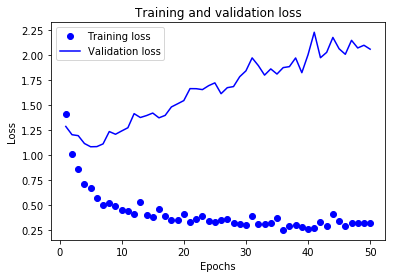

In [86]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

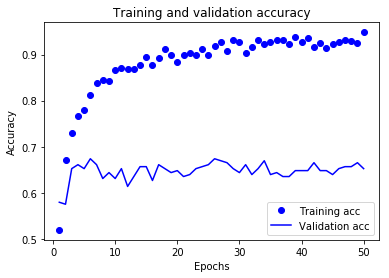

In [87]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.
Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.
This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.
For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.

### Evaluate model

#### Scenario 1: Verify 10 records in test dataset

In [22]:
# Here's how to generate a prediction on individual examples
text_labels = encoder.classes_ 

for i in range(10):
    prediction = model.predict(np.array([x_test_o[i]]))
    predicted_label = text_labels[np.argmax(prediction)]
    print(test_narrative.iloc[i][:50], "...")
    print('Actual label:' + test_product.iloc[i])
    print("Predicted label: " + predicted_label + "\n")

do you have user guide as to what i need to do . f ...
Actual label:Timesheet
Predicted label: Timesheet

as you know there s still missing approver data as ...
Actual label:non-issue
Predicted label: non-issue

we already assigned cheng shin aik staff as 2nd ap ...
Actual label:Authorization
Predicted label: Timesheet

when i click on choose button to select timesheet  ...
Actual label:Timesheet
Predicted label: Timesheet

you must be busy now but there s timesheet missing ...
Actual label:Timesheet
Predicted label: Timesheet

i would like to inform the problem that i couldn t ...
Actual label:Authorization
Predicted label: Timesheet

sorry to bother you please approve my timesheet kh ...
Actual label:Timesheet
Predicted label: Timesheet

could you please set up your browser according to  ...
Actual label:non-issue
Predicted label: non-issue

i d like to check why 0 hour charged following sta ...
Actual label:non-issue
Predicted label: non-issue

i d like to check why 0 hour charged a

#### Scenario 2: Predict category based on manual input

In [23]:
input_sentence = ''
while(1):
    try:
        # Get input sentence
        input_sentence = input('> ')
        # Check if it is quit case
        if input_sentence == 'q' or input_sentence == 'quit': 
            break
        # Normalize sentence
        input_sentence = tokenize.texts_to_matrix([input_sentence])       
        pred_output = model.predict(np.array(input_sentence))
        pred_prob=model.predict_proba(np.array(input_sentence))
        predicted_label = text_labels[np.argmax(pred_output)]
        print('Bot:', ' '.join([predicted_label,'Probality:',str(pred_prob[0,np.argmax(pred_output)])]))
    except KeyError:
        print("Error: Encountered unknown word.")

> I have assigned mr. li with accessing timesheet
Bot: Timesheet Probality: 0.6140563
> quit
